### Multiple testing and High-dimensional Inference ###
In this lecture we will discuss methods for accounting for multiple tests to safe guard against finding too many positives/rejecting too many null hypotheses for useful interpretation or follow-up of analysis tasks.

Let's start by reviewing simple statistical tests.

I generate normally distributed data $X \sim N(0,1)$ and $Y \sim N(0,1)$ and test the Hypothesis: $H_0: \mu_x > \mu_Y$. I use a one-sided hypothesis because it's simpler to illustrate. 

I use a one-sided t-test. What if we don't want to make distribution assumptions? I also run a simple permutation based test to illustrate. That is, I use permutations of the $X$ and $Y$ to estimate the distribution of the test statistic under the null hypothesis - here actually a more general assumption of equal distribution. 


	Two Sample t-test

data:  X and Y
t = 1.9159, df = 198, p-value = 0.02841
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.03798045        Inf
sample estimates:
  mean of x   mean of y 
-0.08303086 -0.35934118 


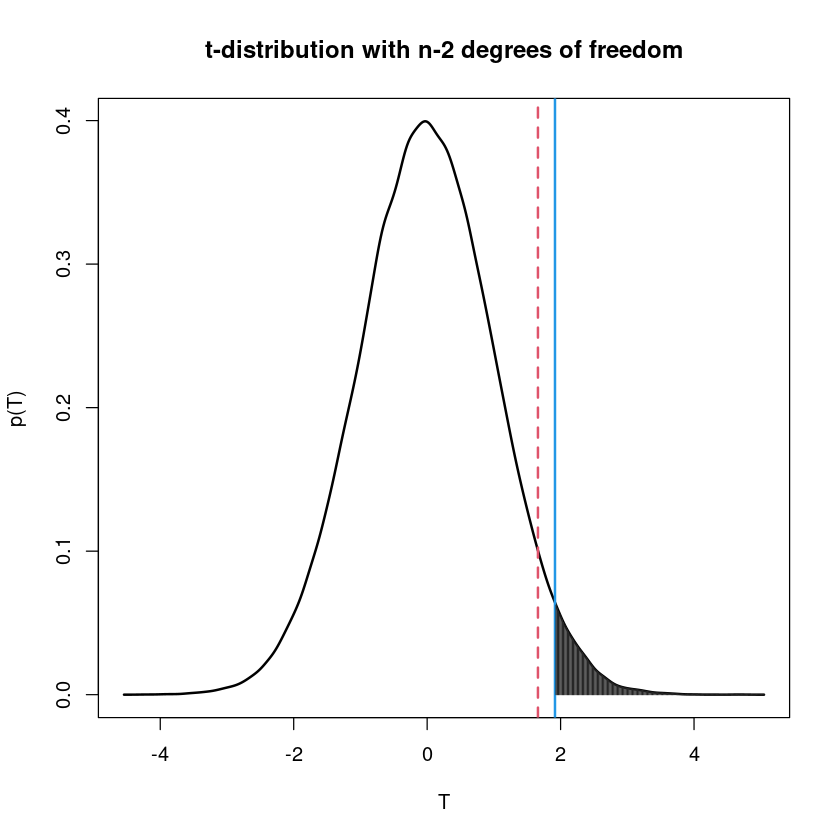

[1] "t_df p-value 0.0284"
[1] "Permutation p-value 0.032"


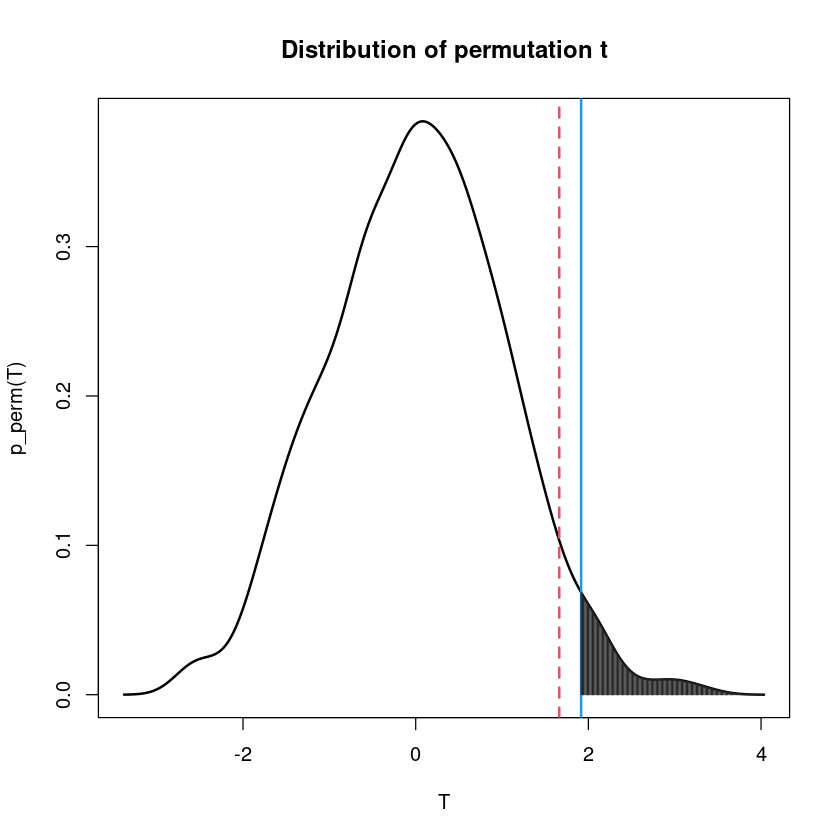

In [3]:
set.seed(1012)         # random seed for reproducibility
#
n <- 100               # sample size
alfa <- 0.05           # level of the test
X <- rnorm(n)
Y <- rnorm(n) - 0.4    # effect size (true difference between the means)
#
TT <- t.test(X,Y,var.equal=T, c("greater")) #one-sided two-sample t-test
TT                     # output from the test - the statistic, degrees of freedom and the p-value
#
library(MASS)
dd <- rt(100000,df=198) # simulating data from the t-density
ddd <- density(dd)      # kernel density estimate
#
plot(ddd$x,ddd$y,type="l",lwd=2, xlab="T",ylab="p(T)",main="t-distribution with n-2 degrees of freedom")
abline(v=TT$stat,col=4,lwd=2)
abline(v=qt(1-alfa,n-2) , lwd=2, lty=2, col=2)
points(ddd$x[ddd$x>TT$stat], ddd$y[ddd$x>TT$stat], type="h", col=gray(.15))
# PERMUTATION TEST
B<-1000               # How many permutations
permT <- rep(0,B)     # Store the test statistics for each permuted data set
for (bb in (1:B)) {
    ii<-sample(seq(1,2*n),n)   # sample half of the data to X and half to Y at random for the test
    Total <- cbind(X,Y)
    permT[bb] <- t.test(Total[ii], Total[-ii], var.equal=T)$stat
}
ddd <- density(permT)
plot(ddd$x,ddd$y,type="l",lwd=2, xlab="T",ylab="p_perm(T)",main="Distribution of permutation t")
abline(v=TT$stat,col=4,lwd=2)
abline(v=quantile(permT,1-alfa), lwd=2, lty=2, col=2)
points(ddd$x[ddd$x>TT$stat], ddd$y[ddd$x>TT$stat], type="h", col=gray(.15))
#
# 
print(paste("t_df p-value",round(TT$p.v,4)))
print(paste("Permutation p-value",length(permT[permT > TT$stat])/B))


OK - that was running one test under the null. 

What do we usually do? We analyze data, e.g. with a model, view the model summary which often includes p-values and draw conclusions. I run logistic regression on the South African heart disease data and view the model summary. 

In [4]:
library(ElemStatLearn)
data(SAheart)
SAheart$famhist <- as.numeric(SAheart$famhist)
mm <- glm(chd ~ ., data=SAheart, family="binomial")
summary(mm) # 5 significant coefficients, but also 9 tests!

ERROR: Error in library(ElemStatLearn): there is no package called ‘ElemStatLearn’


Here we performed 9 tests on coefficients. If we use $\alpha=0.05$ as our significance cutoff, 5 coefficients are found to be significantly different from 0. From previous classes you (hopefully) know to be cautious to interpret p-values one-by-one. First, if there are correlations among the predictors this affects the estimation variance and the p-values. Second, since this is a generalized linear model the p-values are derived from an asymptotic result and last linear approximation in iterative reweighted least squares. 

Here we now also consider one more complication - the fact that you performed multiple tests. Ignoring the possible correlation between the estimates (and therefore the p-values) we know that
$$P(\text{reject at least one of the 9 null hypotheses at level} \ \alpha) = 1-(1-\alpha)^9 \simeq 0.37$$
So, it's quite likely that at least one of the "discoveries" here are false.

How does  $P(\text{reject at least one of the n null hypotheses at level} \ \alpha)$ scale with the number of tests $n$. Let's plot it.

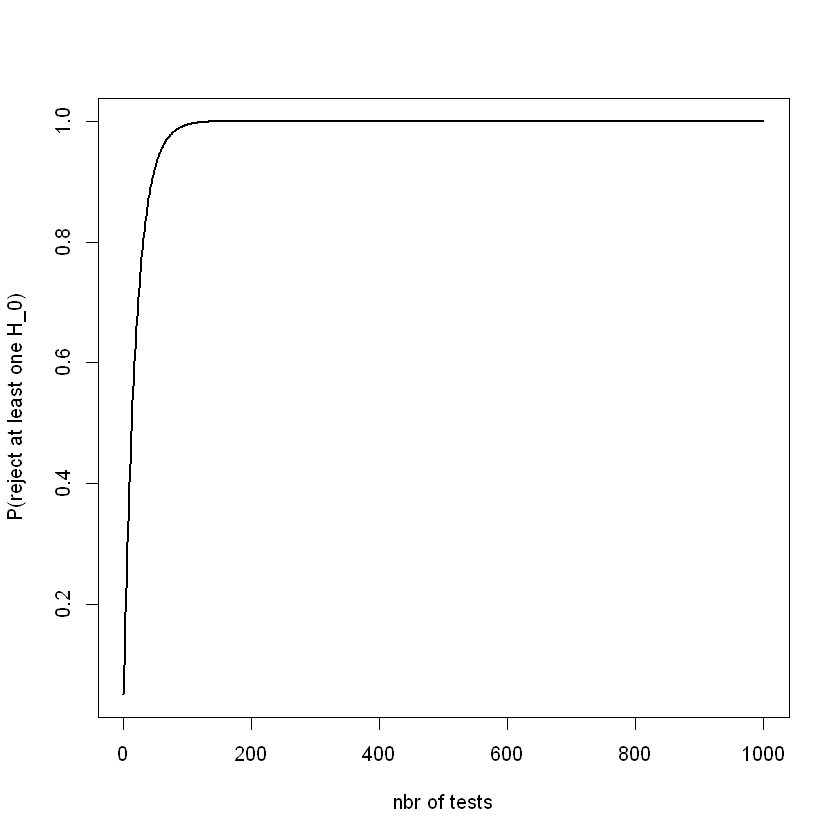

[1] "Probability of at least one false rejection with 9 tests =  0.37"

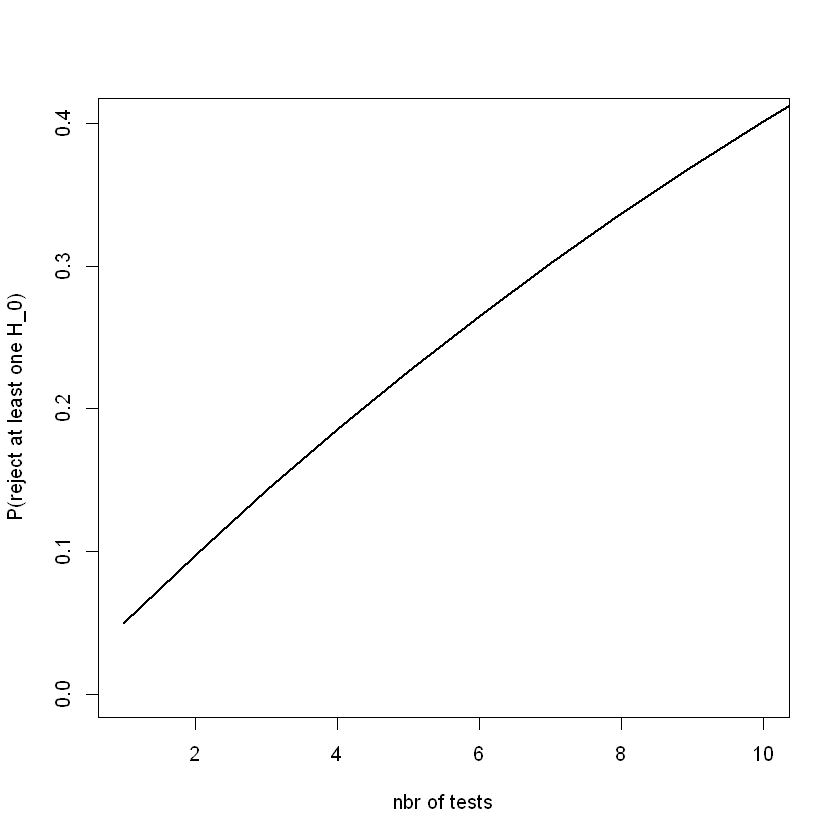

In [ ]:
nbrtest<-seq(1,1000) # how many tests
alfa<-0.05 # level of the test
probreject<-(1-(1-alfa)^nbrtest) #probability of at least one false rejection
plot(nbrtest,probreject,type="l",lwd=2, xlab="nbr of tests",ylab="P(reject at least one H_0)")
plot(nbrtest,probreject,type="l",lwd=2, ylim=c(0, max(probreject[1:10])), xlim=c(1,10),
     xlab="nbr of tests",ylab="P(reject at least one H_0)") # zoom in to the first 10
# From the SA data above
paste("Probability of at least one false rejection with 9 tests = ", round(probreject[9],3))


Once you reach 100 tests you are essentially guaranteed to make at least one false discovery!

#### More on p-values ####
What can we expect to see if we perform multiple tests? What's the distribution of the p-values?

Let's start with the case of all null hypotheses being true.

Warning message in hist.default(ttt, freq = F, 250, main = "histogram of test statistics", :
"arguments 'freq', 'main', 'xlab' are not made use of"
Warning message in hist.default(tt, 250, freq = F, main = "histogram of p-values", :
"arguments 'freq', 'main', 'xlim', 'xlab' are not made use of"


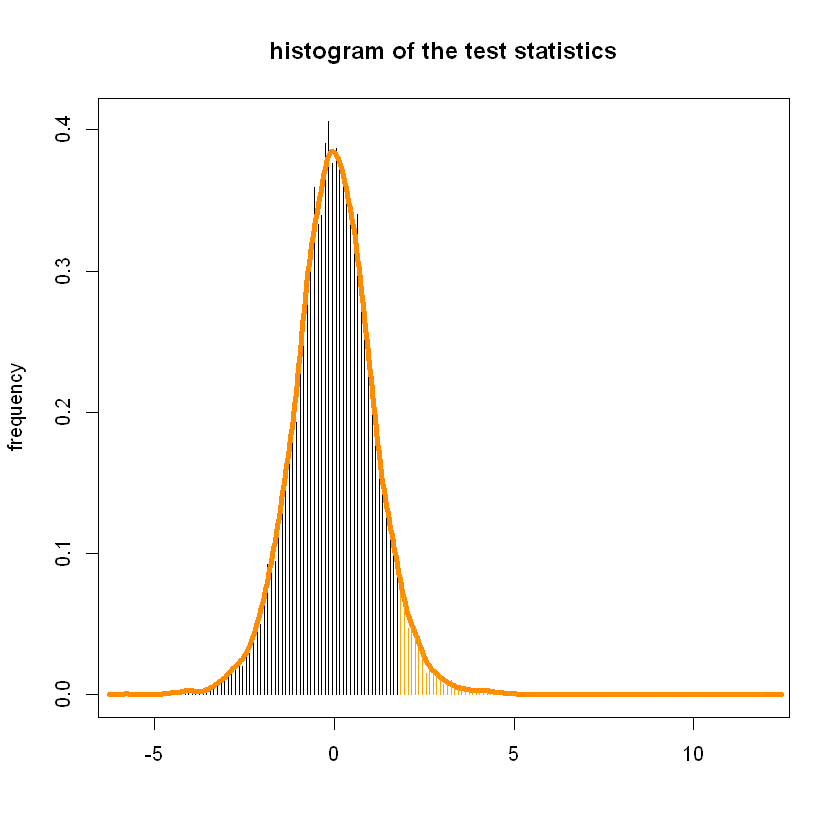

[1] "Proportion of p-values below alpha 0.05 =  0.048"


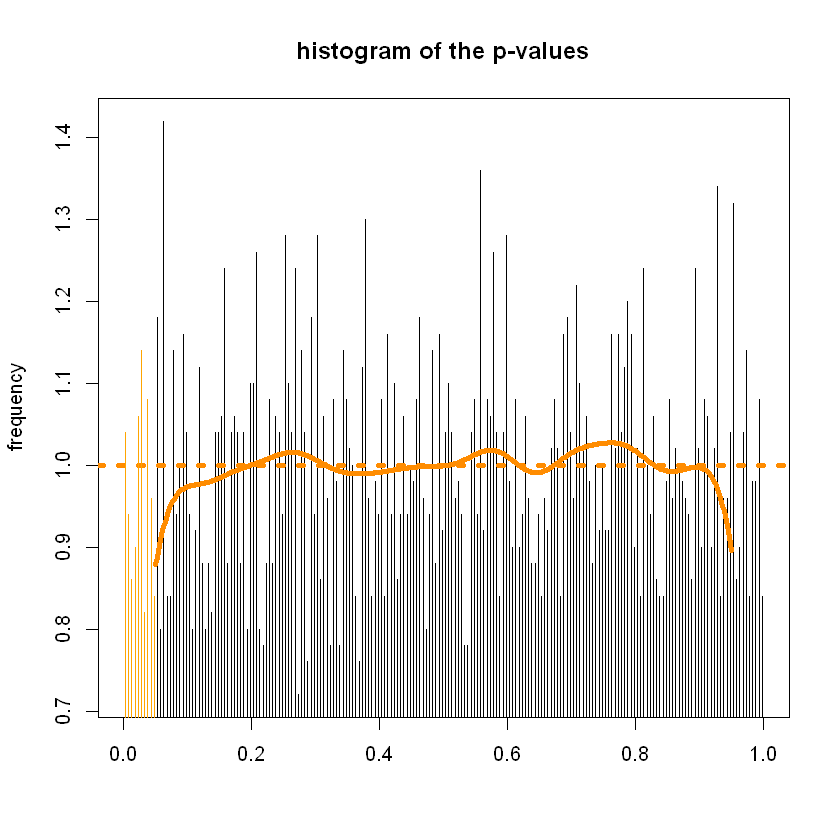

In [ ]:
# All nulls are true
set.seed(1012)
alfa <- 0.05
n <- 10000
d <- 10
X <- matrix(rnorm(n*d),n,d) # n random vectors (number of tests
                            # each vector in d dimensions. Test H0: vector mean=0 against H1: mean>0
getpvalue <- function(x)  {
  out <- t.test(x, alternative="greater")$p.value
}
gettvalue <- function(x)  {
  out <- t.test(x, alternative="greater")$stat
}
# Plot the distribution of the test statistics
ttt<-apply(X,1,gettvalue)
hh <- hist(ttt, freq=F, 250, main="histogram of test statistics",xlab="", plot=F)
plot(hh$mids,hh$density,type="h",xlab="",ylab="frequency", main="histogram of the test statistics")
dd<-density(ttt)
lines(dd$x,dd$y,lwd=4,col="darkorange")
points(hh$mids[hh$mids>qt(.95,d-1)],hh$density[hh$mids>qt(.95,d-1)],col="orange",type="h") # probability mass in the tail above rejection level T=2
# Plot the distribution of the p-values
tt <- apply(X,1,getpvalue)
hh <- hist(tt,250, freq=F, main="histogram of p-values",xlab="", xlim=c(0,1), plot=F)
plot(hh$mids,hh$density,type="h",xlim=c(0,1),xlab="",ylab="frequency", main="histogram of the p-values")
dd<-density(tt,from=0.05,to=.95)
lines(dd$x,dd$y,lwd=4,col="darkorange")
abline(h=1,lwd=4,lty=3,col="darkorange")
points(hh$mids[hh$mids<alfa],hh$density[hh$mids<alfa],type="h",col="orange")
# How many p-values are below the threshhold alpha?
print(paste("Proportion of p-values below alpha 0.05 = ", round(length(tt[tt<0.05])/length(tt),3))) #false positive rate

Notice that the distribution of the p-values are essentially uniform! That is, when the null is true a p-value can fall anywhere in the interval (0,1). If you use the threshhold $\alpha$ you can expect $n \alpha$ of the $n$ p-values to be below this threshhold.

What if the null isn't true? Let's generate data with a few of samples being generated from a different distribution. 

Warning message in hist.default(ttt, freq = F, 250, main = "histogram of test statistics", :
"arguments 'freq', 'main', 'xlab' are not made use of"
Warning message in hist.default(tt, 250, freq = F, main = "histogram of p-values", :
"arguments 'freq', 'main', 'xlim', 'xlab' are not made use of"


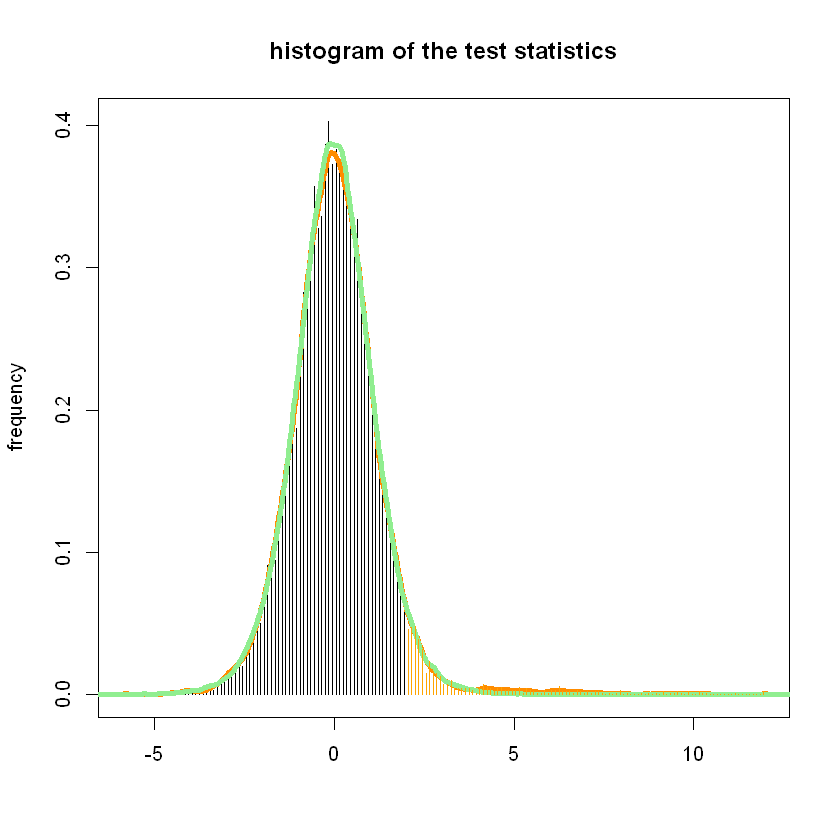

[1] "Proportion of p-values below alpha 0.05 =  0.058"


   
TP  FALSE TRUE
  0  9423  477
  1     0  100

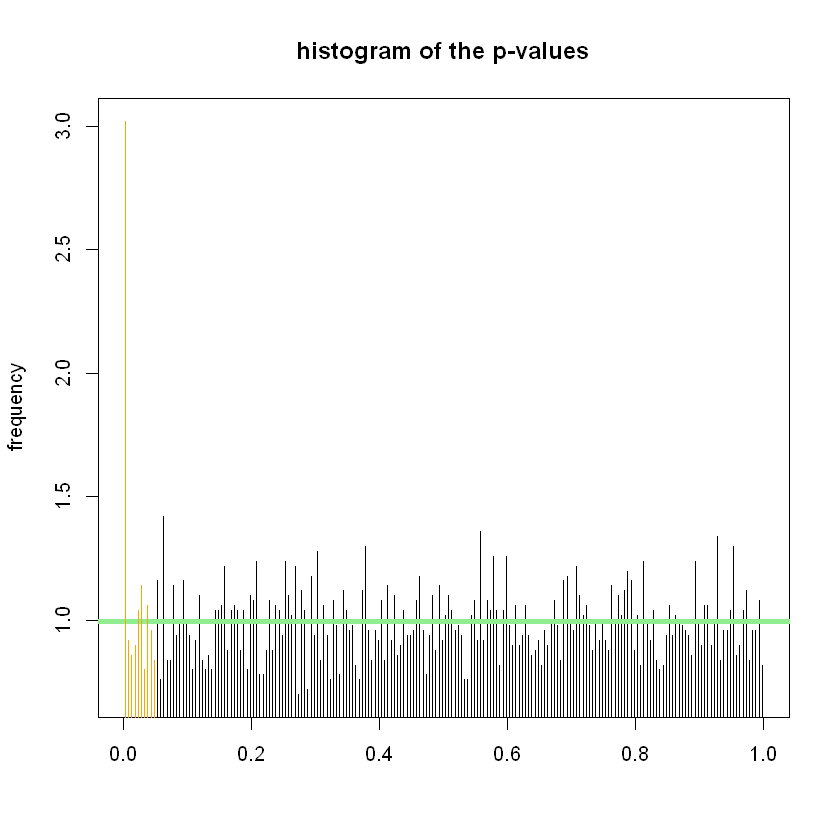

In [ ]:
set.seed(1012)
# p-values when some of the tests are NOT from the null
n <- 10000 # number of tests
d <- 10
alfa <- 0.05
X <- matrix(rnorm(n*d),n,d) # n random vectors (number of tests
                            # each vector in d dimensions. Test H0: vector mean=0 against H1: mean>0
#
m0 <- 100  # number of vectors where the null H0: mean=0 is NOT true
n0 <- n-m0 # number of true nulls
X[1:m0,] <- X[1:m0,] + 2  # Effect size for the non-nulls
#### 
# Plot the test statistics
ttt<-apply(X,1,gettvalue)
hh <- hist(ttt, freq=F, 250, main="histogram of test statistics",xlab="", plot=F)
plot(hh$mids,hh$density,type="h",xlab="",ylab="frequency", main="histogram of the test statistics")
dd<-density(ttt) # the observed distribution of the test statistic
lines(dd$x,dd$y,lwd=4,col="darkorange")
dd<-density(rt(n*d,df=d-1)) # the null distribution of the test statistic
lines(dd$x,dd$y,lwd=4,col="lightgreen")
points(hh$mids[hh$mids>2],hh$density[hh$mids>2],col="orange",type="h") # probability mass in the tail above rejection level T=2
# Plot the p-values
tt <- apply(X,1,getpvalue)
hh <- hist(tt, 250, freq=F, main="histogram of p-values",xlab="", xlim=c(0,1), plot=F)
plot(hh$mids,hh$density,type="h",xlim=c(0,1),xlab="",ylab="frequency", main="histogram of the p-values")
abline(h=mean(hh$density[hh$mids>0.5]),lwd=4,col="lightgreen")
points(hh$mids[hh$mids<alfa],hh$density[hh$mids<alfa],type="h",col="orange")
####
# How many of the n tests lead to rejection?
print(paste("Proportion of p-values below alpha 0.05 = ", round(length(tt[tt<0.05])/length(tt),3))) #
TP <- c(rep(1,m0),rep(0,n-m0))
table(TP,tt<alfa)

Notice how there is now an "excess" of small p-values compared to the uniform distribution (and a slightly fatter tail of the test statistic). This is an indication that some of the null hypotheses are not true. Remember though that for the $n_0$ true nulls, the p-values still come from U(0,1) so may well also be localized to the low end of the distribution.

One way to safe-guard against making too many false rejections was using a more stringent level for the test. The Bonferroni correction used $\alpha/n$ as the adjusted level of the test. 

Let's try it.

In [ ]:
table(TP,tt<alfa/n) # Bonferroni

   
TP  FALSE TRUE
  0  9899    1
  1    84   16

This is really conservative! 

In the lecture we talked about changing focus from safe guarding agains making *any* false rejections and instead focusing on the proportion of rejections that are false. That is, among your detections how many are likely to be false?

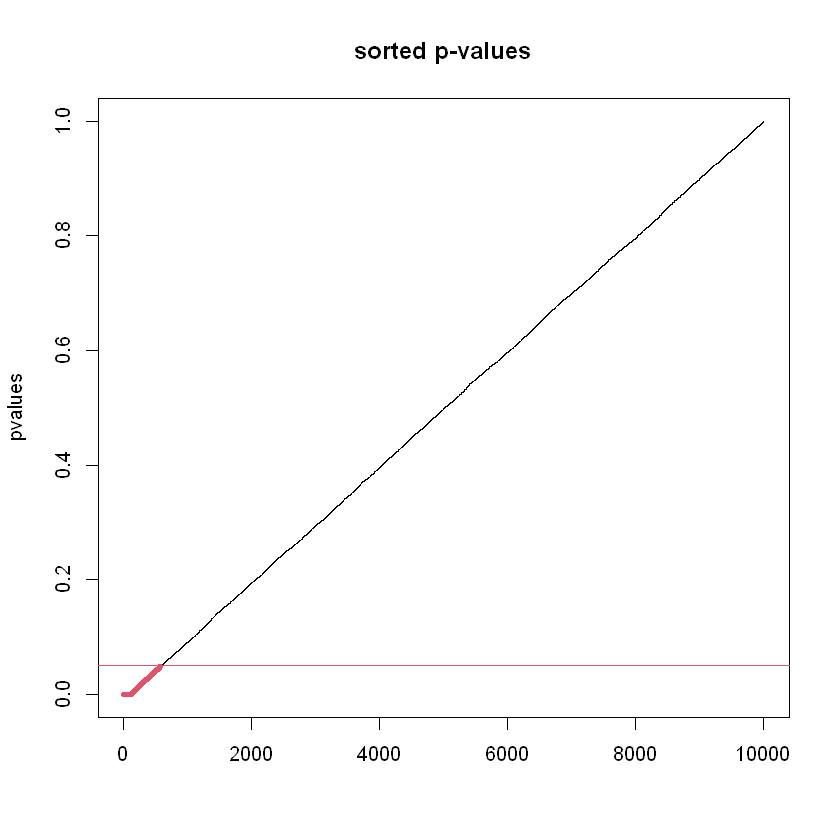

In [ ]:
ps <- sort(tt) # sort the p-values
plot(seq(1,length(ps)),(ps),type="l",main="sorted p-values",xlab="",ylab="pvalues")
abline(h=0.05,col=2) # alpha = 0.05 threshhold. Lot's of rejections
points(seq(1,length(ps[ps<alfa])),(ps[ps<alfa]),col=2,cex=0.5,pch=16)

Plotting the p-values on a log10 scale puts more focus on the small p-values.

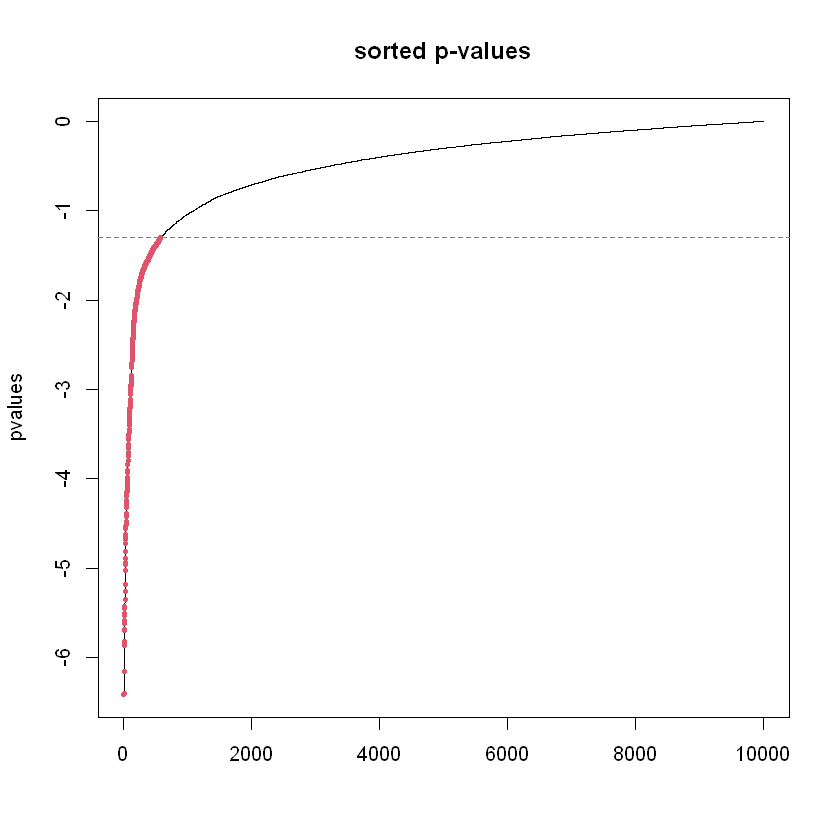

In [ ]:
ps <- sort(tt)
plot(seq(1,length(ps)),log10(ps),type="l",main="sorted p-values",xlab="",ylab="pvalues")
abline(h=log10(alfa),col=2,lty=2) # alpha = 0.05 threshhold
points(seq(1,length(ps[ps<alfa])),log10(ps[ps<alfa]),col=2,cex=0.5,pch=16)

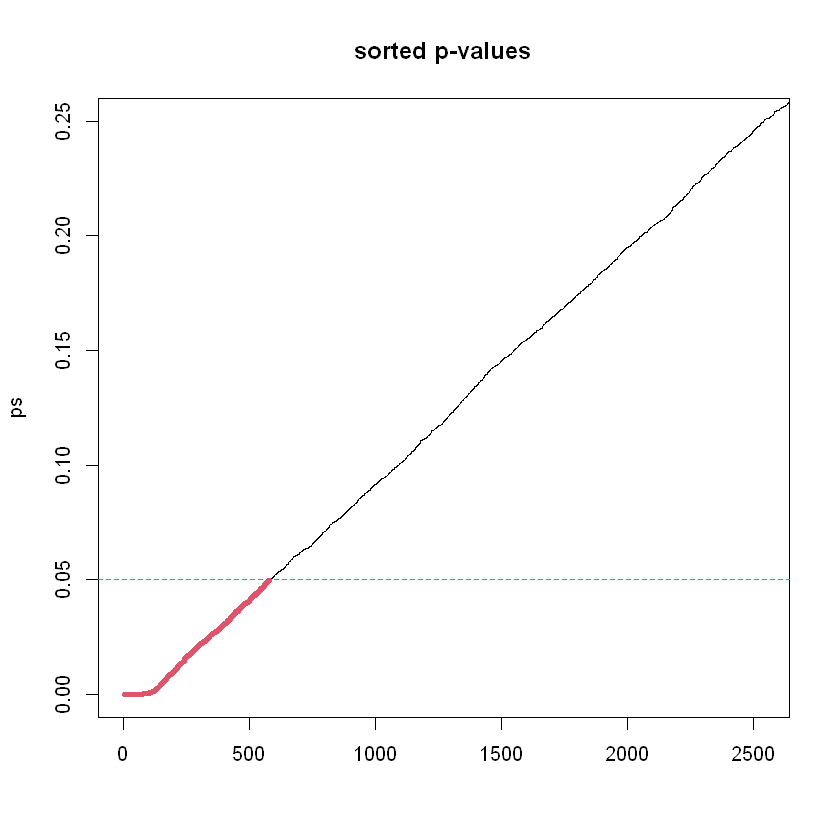

In [ ]:
# zoom in
ps <- sort(tt)
plot(seq(1,length(ps)),ps, type="l",main="sorted p-values",xlab="", xlim=c(0,max(seq(1,n)[ps<0.25])),ylim=c(0,.25), ylab=)
abline(h=alfa,col=2, lty=2)
points(seq(1,length(ps[ps<alfa])),ps[ps<alfa],col=2,cex=0.5,pch=16)

Let's zoom in on the small p-values and add the Bonferroni threshhold to the figure (in blue). 

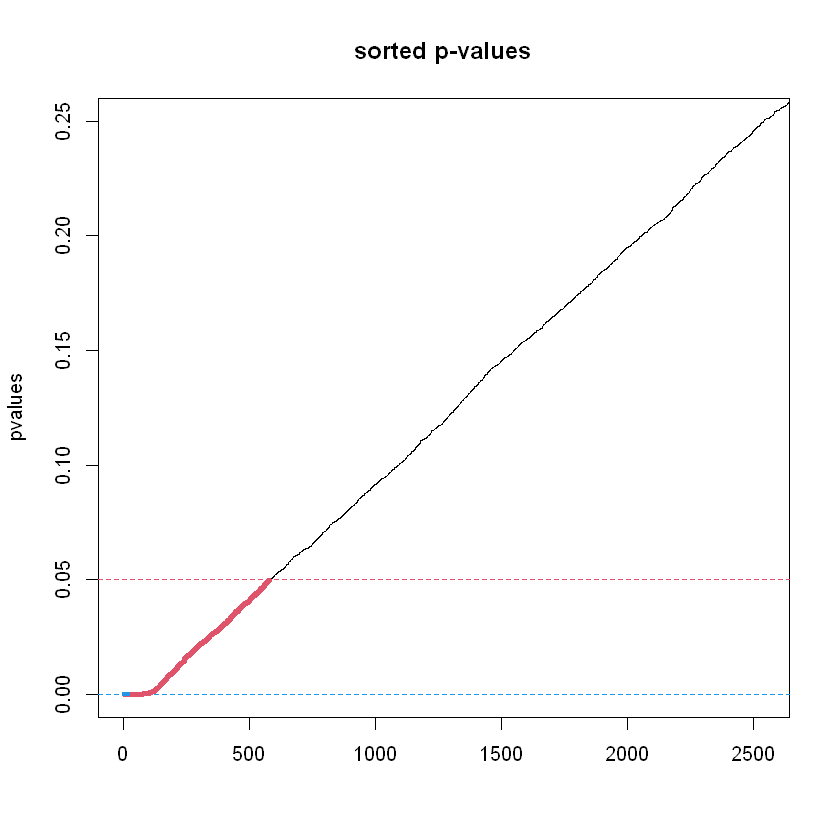

In [ ]:
# zoom in
ps <- sort(tt)
plot(seq(1,length(ps)),ps, type="l",main="sorted p-values",xlab="", xlim=c(0,max(seq(1,n)[ps<0.25])),
     ylim=c(0,.25), ylab="pvalues")
abline(h=alfa,col=2, lty=2)
abline(h=alfa/n,col=4, lty=2)
points(seq(1,length(ps[ps<alfa])),ps[ps<alfa],col=2,cex=0.5,pch=16)
points(seq(1,length(ps[ps<alfa/n])),ps[ps<alfa/n],col=4,cex=0.5,pch=15)

Here you can see the few detections that we got using the Bonferroni correction (blue points below the blue dashed line at $\alpha/n$).

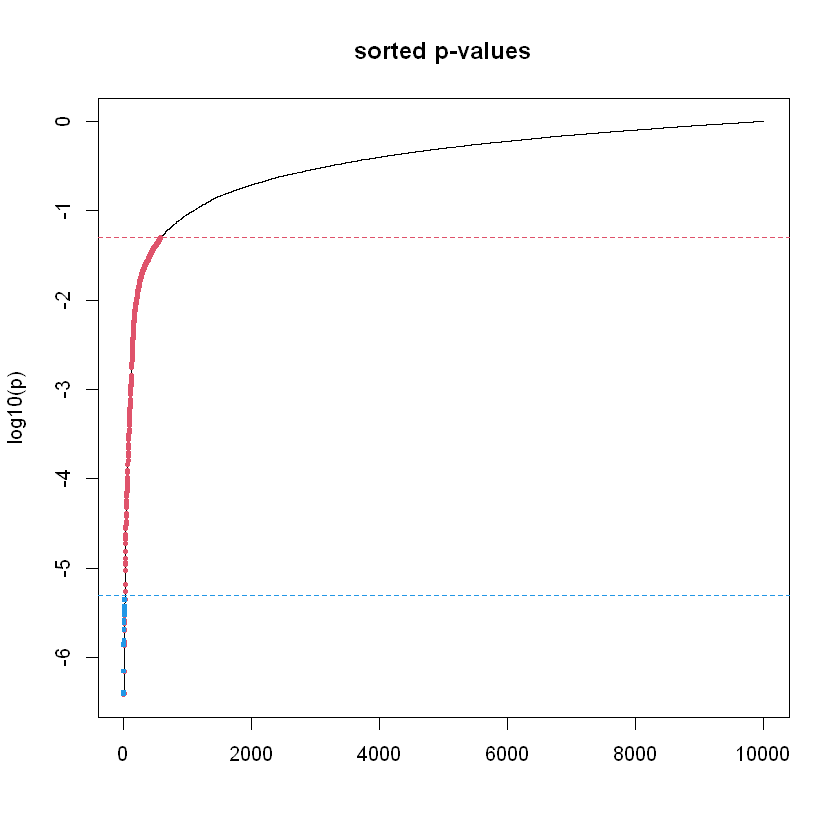

In [ ]:
# zoom in on a log10 scale
ps <- sort(tt)
plot(seq(1,length(ps)),log10(ps), type="l",main="sorted p-values",xlab="", ylab="log10(p)")
abline(h=log10(alfa),col=2, lty=2)
abline(h=log10(alfa/n),col=4, lty=2)
points(seq(1,length(ps[ps<alfa])),log10(ps[ps<alfa]),col=2,cex=0.5,pch=16)
points(seq(1,length(ps[ps<alfa/n])),log10(ps[ps<alfa/n]),col=4,cex=0.5,pch=15)

#### Benjamini-Hochberg and False Discovery Rate ####

Let's try controlling the false discovery rate instead of the FWER (familywise error rate, probability of making at least one false rejection).

The BH procedure compares the sorted p-value to the diagonal cutoff with slope $\alpha$, i.e. the $r$-th smallest p-value should not exceed $\alpha (r/n)$ if you want to safe-guard against a false discovery rate of $\alpha$. Note, here you don't have to use $\alpha=0.05$ or $0.01$ but can use a thresshold that results in an "affordable" number of discoveries/follow-up experiments.

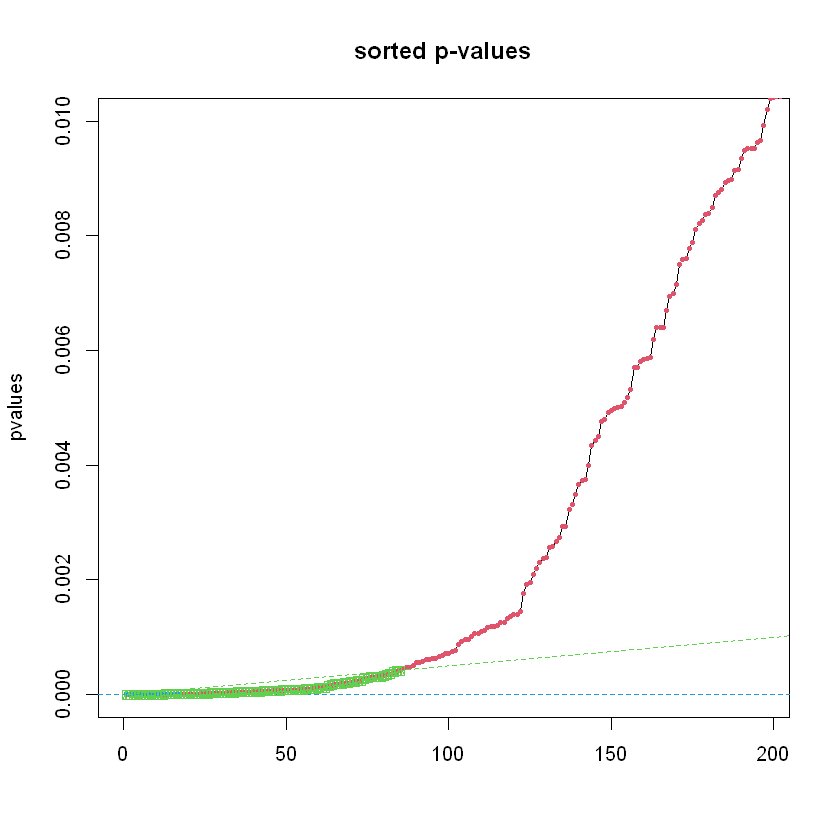

In [ ]:
#  sorted p-values, zoomed in.
ps <- sort(tt)
plot(seq(1,length(ps)),ps, type="l",main="sorted p-values",xlab="", xlim=c(0,max(seq(1,n)[ps<0.01])),
     ylim=c(0,.01), ylab="pvalues")
abline(h=alfa, col=2, lty=2)  # standard test threshhold
abline(h=alfa/n,col=4, lty=2) # Bonferroni
points(seq(1,length(ps[ps<alfa])),ps[ps<alfa],col=2,cex=0.5,pch=16) # detected with standard threshhold
points(seq(1,length(ps[ps<alfa/n])),ps[ps<alfa/n],col=4,cex=0.5,pch=15) # detected with Bonferroni
#
lines(seq(1,n),alfa*seq(1,n)/n,col=3,lty=2) # the BH slope comparison 
aa<-alfa*seq(1,n)/n
points(seq(1,length(ps[ps<aa])),ps[ps<aa],col=3,pch=14) # the BH detected points

   
    FALSE TRUE
  0  9897    3
  1    18   82

[1] "FDP observed =  0.0353"


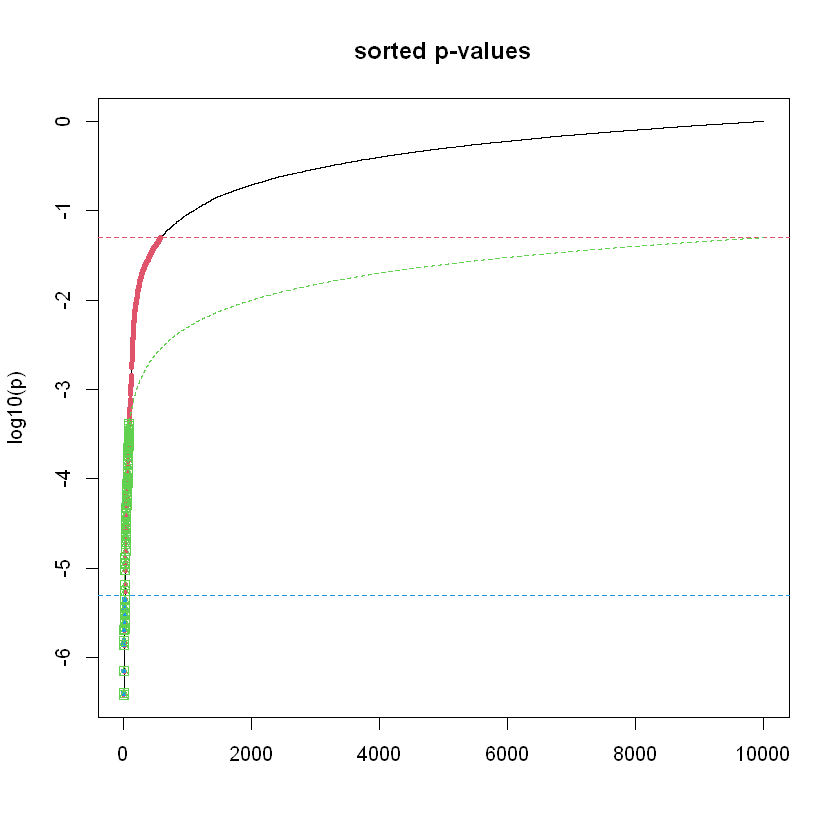

In [ ]:
# zoom in
ps <- sort(tt)
plot(seq(1,length(ps)),log10(ps), type="l",main="sorted p-values",xlab="", ylab="log10(p)")
abline(h=log10(alfa),col=2, lty=2)
abline(h=log10(alfa/n),col=4, lty=2)
points(seq(1,length(ps[ps<alfa])),log10(ps[ps<alfa]),col=2,cex=0.5,pch=16)
points(seq(1,length(ps[ps<alfa/n])),log10(ps[ps<alfa/n]),col=4,cex=0.5,pch=15)
aa<-alfa*seq(1,n)/n
lines(seq(1,n),log10(aa),col=3,lty=2)
points(seq(1,length(ps[ps<aa])),log10(ps[ps<aa]),col=3,pch=14)
#### BH detections
Tab <- table(TP[sort.list(tt)],ps<aa)
Tab
FDP <- Tab[1,2]/sum(Tab[,2])
print(paste("FDP observed = ", round(FDP,4)))

In [5]:
#install.packages("multtest")
library(multtest) # a library in R with many different p-value adjustment methods
p.adj<-p.adjust(tt, method="BH") # same as ps<aa above 
table(TP,p.adj<0.05)

Installing package into ‘/home/johan/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Warning message:
“unable to access index for repository https://cloud.r-project.org/src/contrib:
  cannot open URL 'https://cloud.r-project.org/src/contrib/PACKAGES'”
Warning message:
“package ‘multtest’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


ERROR: Error in library(multtest): there is no package called ‘multtest’


At $\alpha=0.05$ we obtain more discoveries but of course some are not true. The observed false discovery proportion may not be $\alpha$ since we only control FDR, i.e. the FDP in expectation. 

Let's run this multiple times to observe.

In [ ]:
set.seed(1012)
# p-values when some of the tests are NOT from the null
n <- 10000 # number of tests
d <- 10
alfa <- 0.05
#
m0 <- 100  # number of vectors where the null H0: mean=0 is NOT true
n0 <- n-m0 # number of true nulls
TP <- c(rep(1,m0),rep(0,n-m0))
#### 
B <- 100 # number of repeats
FPv <- matrix(0,B,3) # to record the number of false positives for standard, Bonferroni and BH
FDPv <- matrix(0,B,3)
for (bb in (1:B)) {
   X <- matrix(rnorm(n*d),n,d) # n random vectors (number of tests
                            # each vector in d dimensions. Test H0: vector mean=0 against H1: mean>0
   X[1:m0,] <- X[1:m0,] + 2  # Effect size for the non-nulls
   # get the test statistics
   tt <- apply(X,1,getpvalue)
   t1 <- table(TP,tt<alfa)  # standard testing
   FPv[bb,1] <- t1[1,2]
   FDPv[bb,1] <- t1[1,2]/sum(t1[,2])
   t2<- table(TP,tt<alfa/n) # Bonferroni
   FPv[bb,2] <- t2[1,2]
   FDPv[bb,2] <- t2[1,2]/sum(t2[,2])
   aa<-alfa*seq(1,n)/n
   ps<-sort(tt)
   t3<-table(TP[sort.list(tt)],ps<aa)
   FPv[bb,3] <- t3[1,2]
   FDPv[bb,3] <- t3[1,2]/sum(t3[,2]) }
####

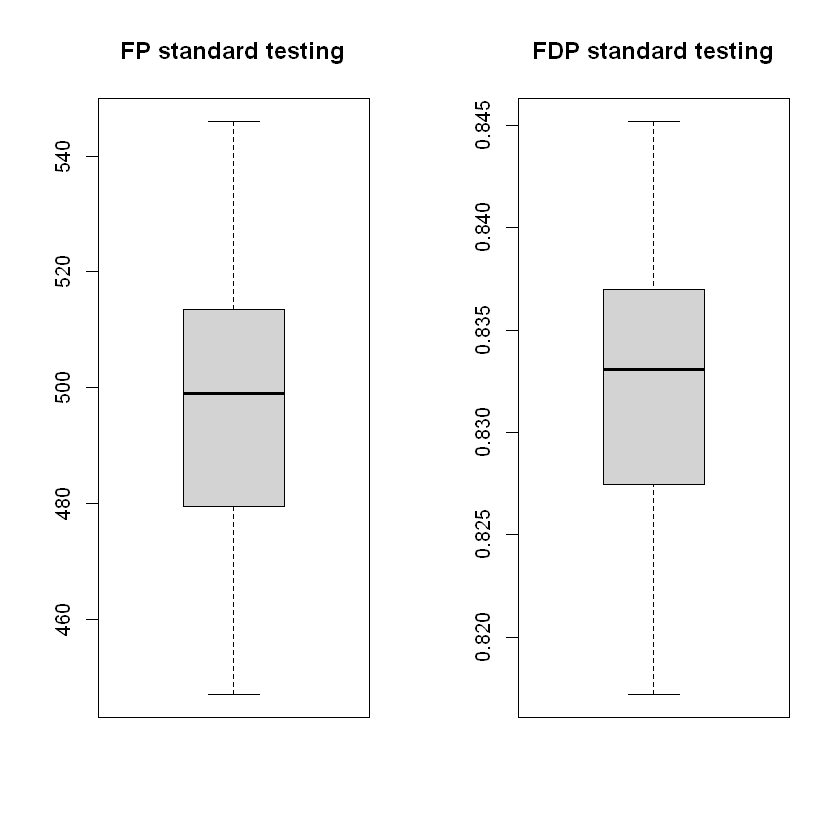

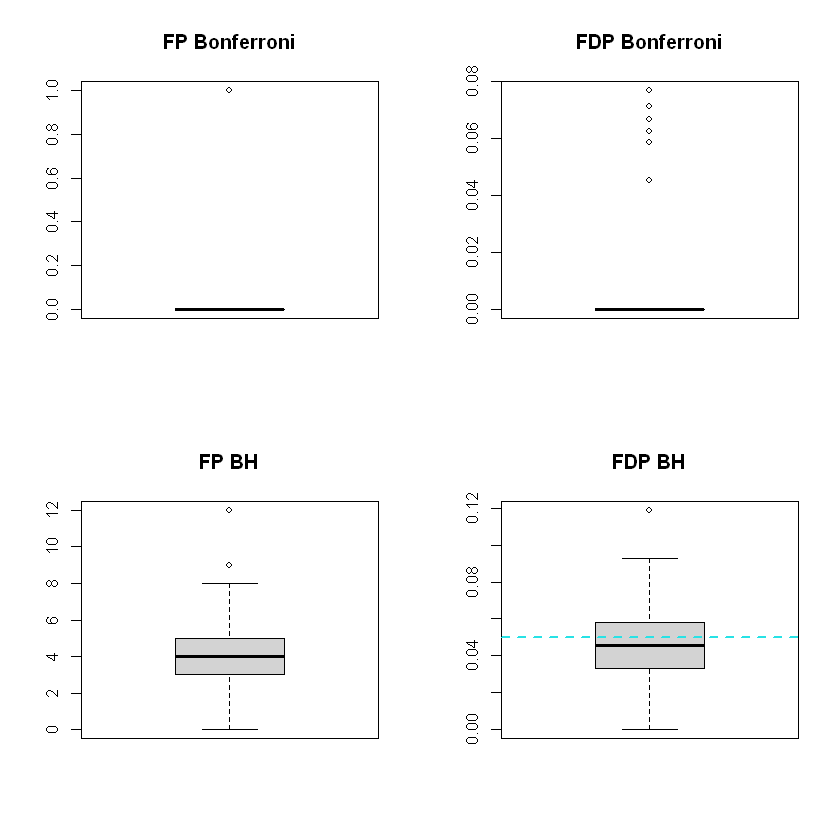

In [ ]:
par(mfrow=c(1,2))
boxplot(FPv[,1], main="FP standard testing")
boxplot(FDPv[,1], main="FDP standard testing")
par(mfrow=c(2,2))
boxplot(FPv[,2], main="FP Bonferroni")
boxplot(FDPv[,2], main="FDP Bonferroni")
boxplot(FPv[,3], main="FP BH")
boxplot(FDPv[,3], main="FDP BH")
abline(h=alfa,lty=2,col=5,lwd=2)

The BH procedure controls the expected FDP, the False Discovery Rate.

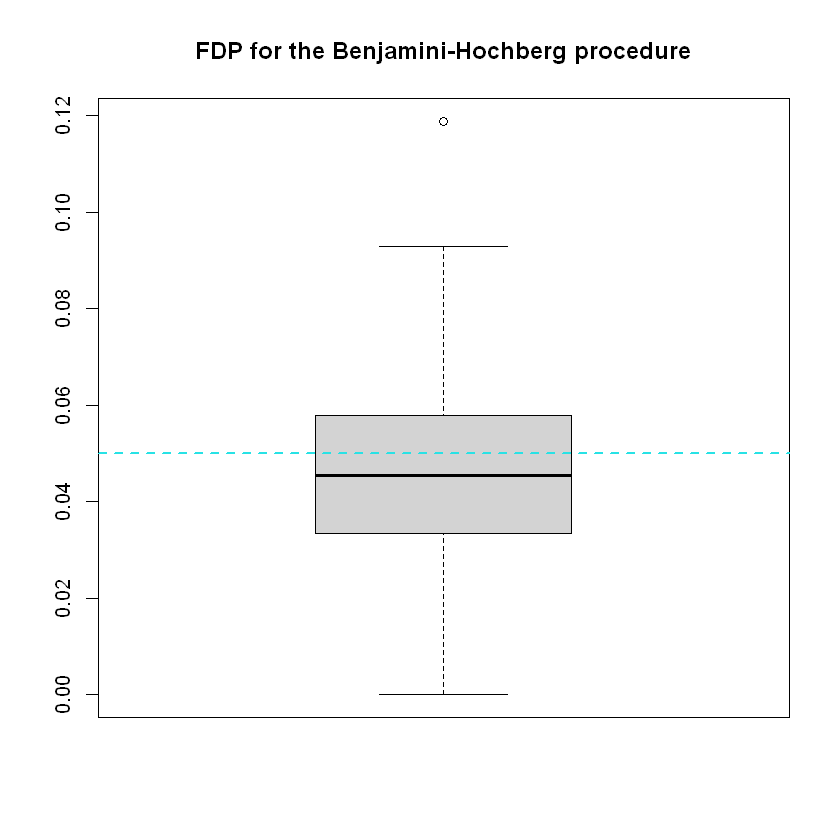

In [ ]:
boxplot(FDPv[,3], main="FDP for the Benjamini-Hochberg procedure")
abline(h=alfa,lty=2,col=5,lwd=2)

Let's have another look at the digits data. Now, there are a lot of digits so we will use only a few of to test which pixels differ between the digits.

Next few lectures we will discuss testing when the sample size is large - when p-values are difficult to use because everything becomes significant...

Let's start by just comparing 0s and 1s.

In [ ]:
library(ElemStatLearn)
Nmat<-zip.train
#
diguse <- c(0,1) # 0s and 1s
nuse <- 10       # how many of each
for (ii in (1:length(diguse))) { 
   if (ii == 1) {
     iz <- sample((seq(1,dim(Nmat)[1])[Nmat[,1]==diguse[ii]]),nuse) }
   if (ii > 1) {
     iz <- c(iz,sample((seq(1,dim(Nmat)[1])[Nmat[,1]==diguse[ii]]),nuse)) }
    }
#
Nmatu<-Nmat[iz,]
Nmatu[,-1]<-Nmatu[,-1]+matrix(rnorm(dim(Nmatu[,-1])[1]*dim(Nmatu[,-1])[2]),dim(Nmatu[,-1])[1],dim(Nmatu[,-1])[2])*.001 
# added a small random element since t.test doesn't like exact 0 test statistics
table(Nmatu[,1]) # just 0s and 1s - nuse of each
# 256 digits to test
digtest <- function(x,y) {
    t.test(x~as.factor(y))$p.val }
#### all the pixel-wise p.values
tt <- apply(Nmatu[,-1],2,digtest,y=as.factor(Nmatu[,1]))


 0  1 
10 10 

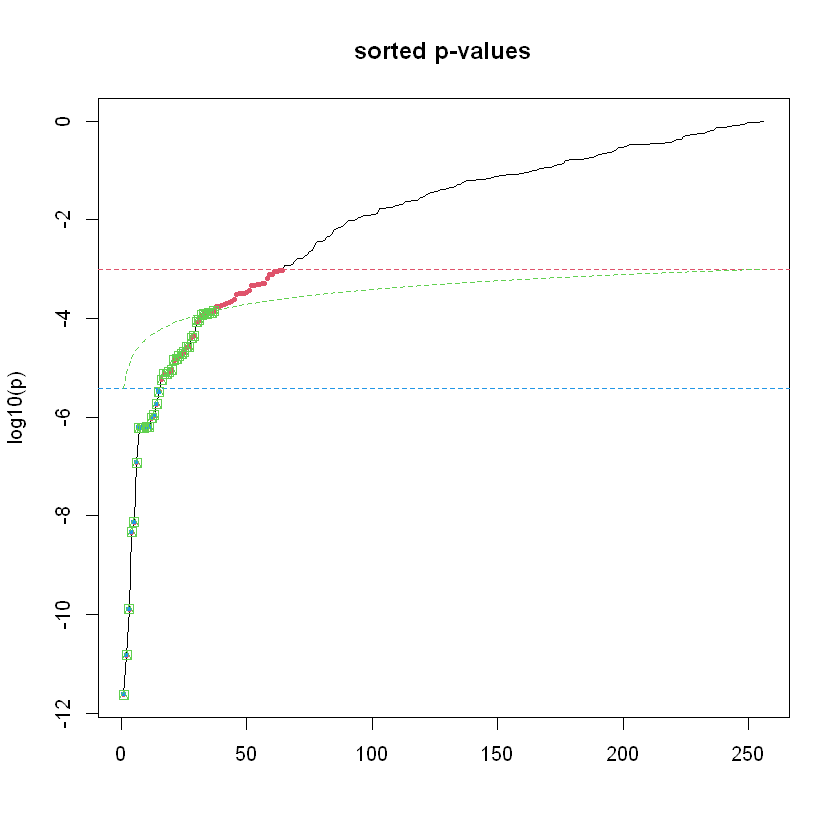

In [ ]:
alfa <- 0.001 # change as you will
nu <- 256
####
ps <- sort(tt)
plot(seq(1,length(ps)),log10(ps), type="l",main="sorted p-values",xlab="", ylab="log10(p)")
#
abline(h=log10(alfa),col=2, lty=2)      # standard test
abline(h=log10(alfa/nu),col=4, lty=2)   # Bonferroni
points(seq(1,length(ps[ps<alfa])),log10(ps[ps<alfa]),col=2,cex=0.5,pch=16)
points(seq(1,length(ps[ps<alfa/nu])),log10(ps[ps<alfa/nu]),col=4,cex=0.5,pch=15)
aa<-alfa*seq(1,nu)/nu
lines(seq(1,nu),log10(aa),col=3,lty=2)  # BH
points(seq(1,length(ps[ps<aa])),log10(ps[ps<aa]),col=3,pch=14)


Let's plot the pixel-wise p-values and the significant pixels for the 0-1 comparison.

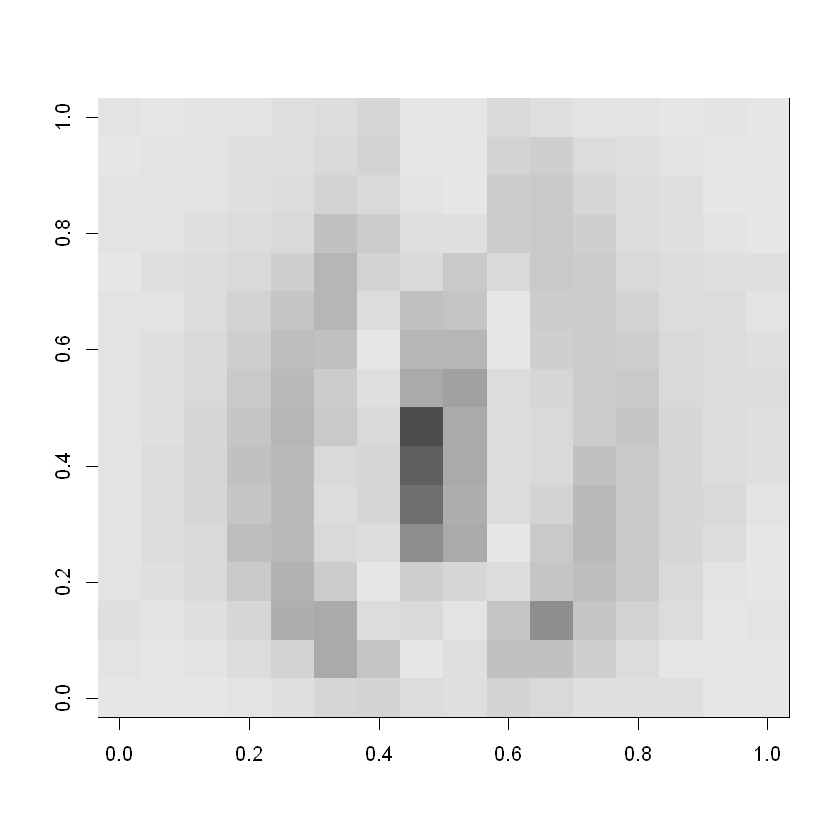

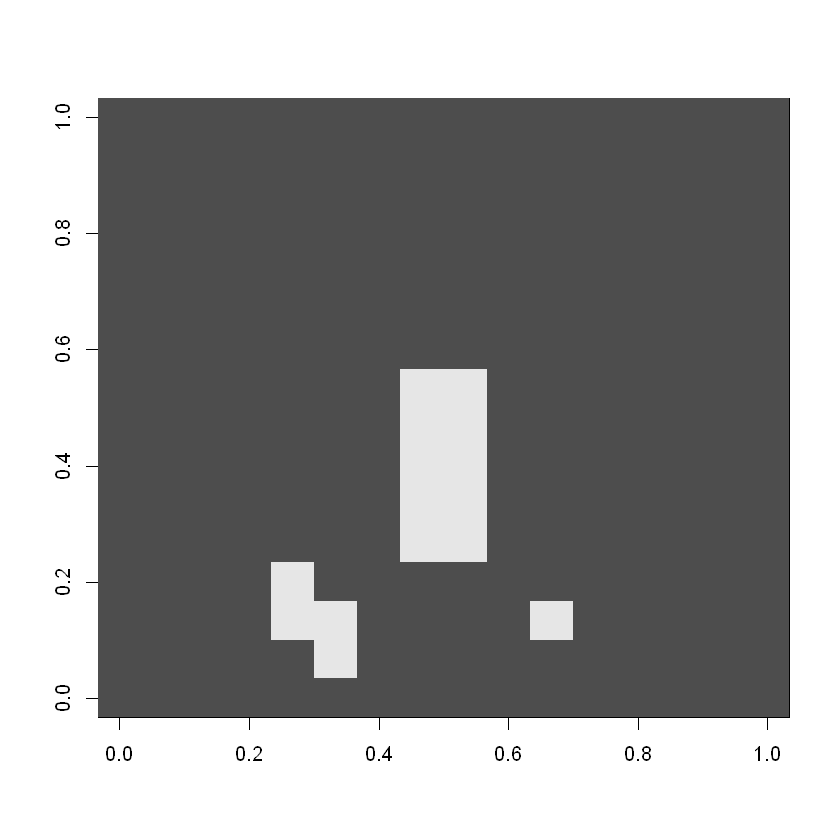

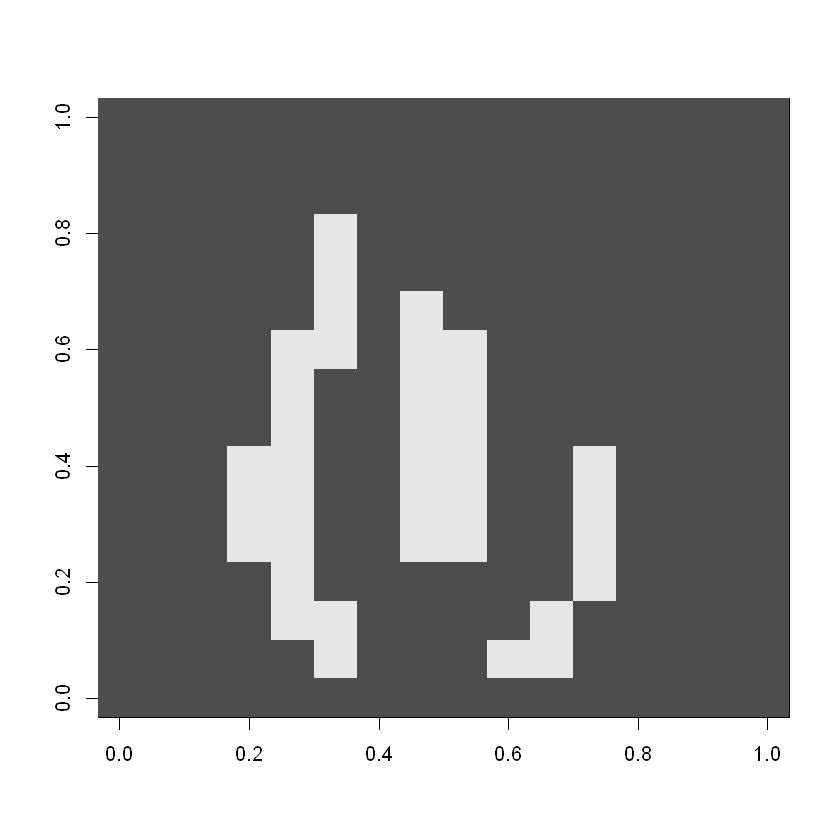

In [ ]:
ii <- seq(1,dim(Nmatu[,-1])[2])[tt<alfa/nu] # the Bonferroni significant pixels
#
image(t(matrix(as.numeric(log10(tt)),16,16,byrow=T))[,16:1], col = gray.colors(33)) 
      # the raw p-values - dark means smaller p-value
#
Picimage <- rep(0,256)
Picimage[ii] <- 1
image(t(matrix(as.numeric(Picimage),16,16,byrow=T))[,16:1], col = gray.colors(33)) # Bonferroni selected 
#
p.adj<-p.adjust(tt,"BH")
ii <- seq(1,dim(Nmatu[,-1])[2])[p.adj<alfa]
Picimage <- rep(0,256)
Picimage[ii] <- 1
image(t(matrix(as.numeric(Picimage),16,16,byrow=T))[,16:1], col = gray.colors(33)) # BH selected

Try another set of digits.

In [ ]:
digtestall <- function(x,y) {
    summary(aov(x~as.factor(y)))[[1]][["Pr(>F)"]][1] }
Nmat<-zip.train
table(Nmat[,1])
#
diguse <- c(2,3,7) # 2s and 3s and 7s
nuse <- 10 # how many of each
for (ii in (1:length(diguse))) { 
   if (ii == 1) {
     iz <- sample((seq(1,dim(Nmat)[1])[Nmat[,1]==diguse[ii]]),nuse) }
   if (ii > 1) {
     iz <- c(iz,sample((seq(1,dim(Nmat)[1])[Nmat[,1]==diguse[ii]]),nuse)) }
    }
#
Nmatu<-Nmat[iz,]
Nmatu[,-1]<-Nmatu[,-1]+matrix(rnorm(dim(Nmatu[,-1])[1]*dim(Nmatu[,-1])[2]),dim(Nmatu[,-1])[1],dim(Nmatu[,-1])[2])*.001 
# added a small random element since t.test doesn't like exact 0 test statistics
table(Nmatu[,1]) # 
#
tt <- apply(Nmatu[,-1],2,digtestall,y=as.factor(Nmatu[,1]))


   0    1    2    3    4    5    6    7    8    9 
1194 1005  731  658  652  556  664  645  542  644 


 2  3  7 
10 10 10 

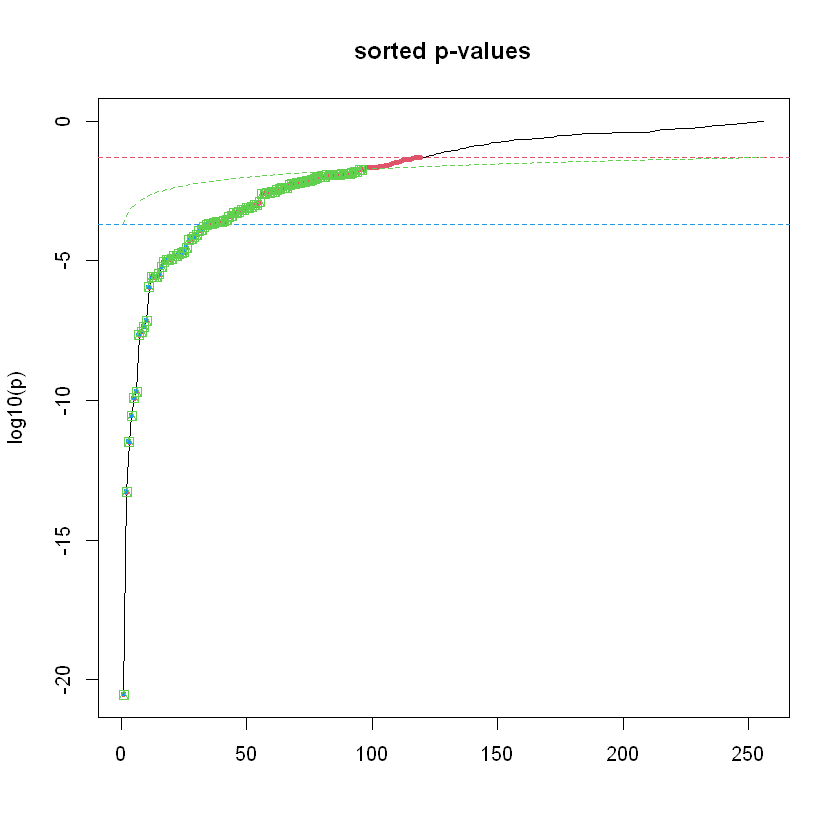

In [ ]:
alfa <- 0.05
nu <- 256
ps <- sort(tt)
plot(seq(1,length(ps)),log10(ps), type="l",main="sorted p-values",xlab="", ylab="log10(p)")
abline(h=log10(alfa),col=2, lty=2)
abline(h=log10(alfa/nu),col=4, lty=2)
points(seq(1,length(ps[ps<alfa])),log10(ps[ps<alfa]),col=2,cex=0.5,pch=16)
points(seq(1,length(ps[ps<alfa/nu])),log10(ps[ps<alfa/nu]),col=4,cex=0.5,pch=15)
aa<-alfa*seq(1,nu)/nu
lines(seq(1,nu),log10(aa),col=3,lty=2)
points(seq(1,length(ps[ps<aa])),log10(ps[ps<aa]),col=3,pch=14)


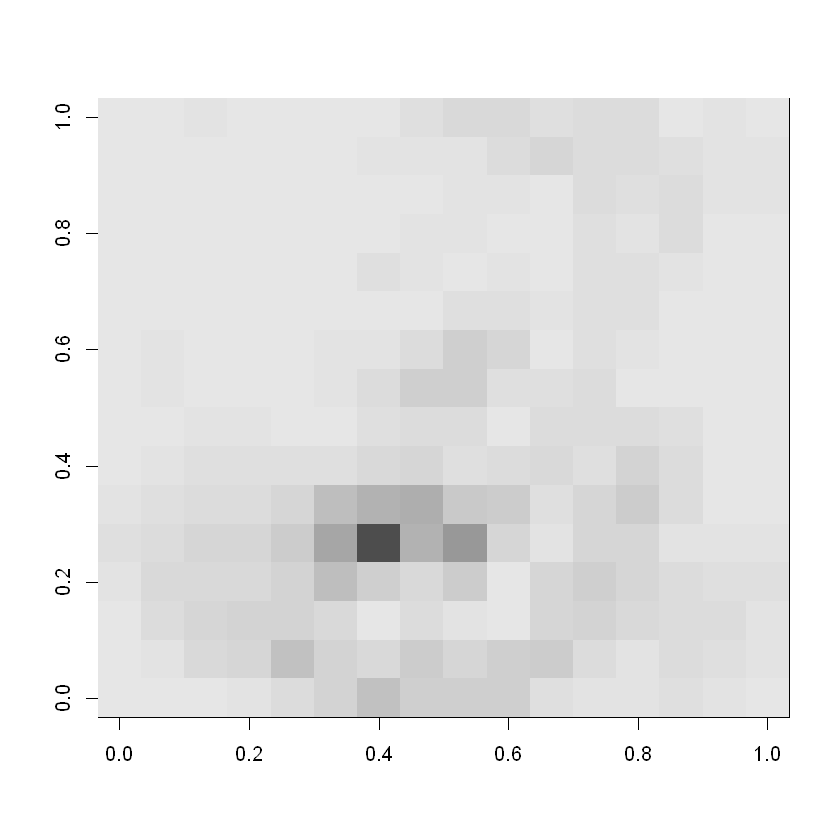

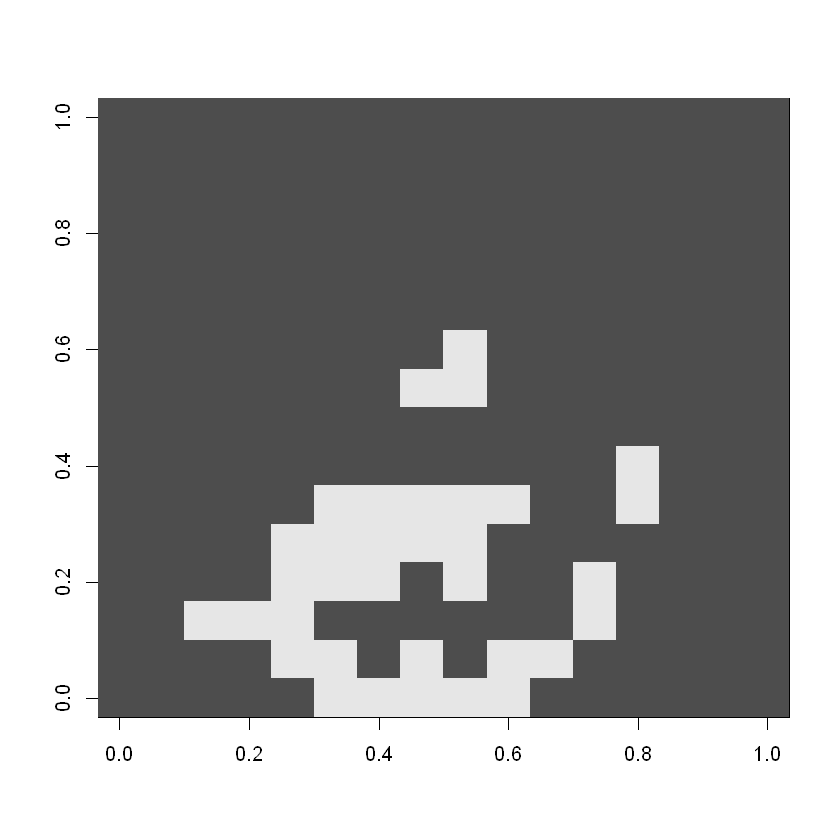

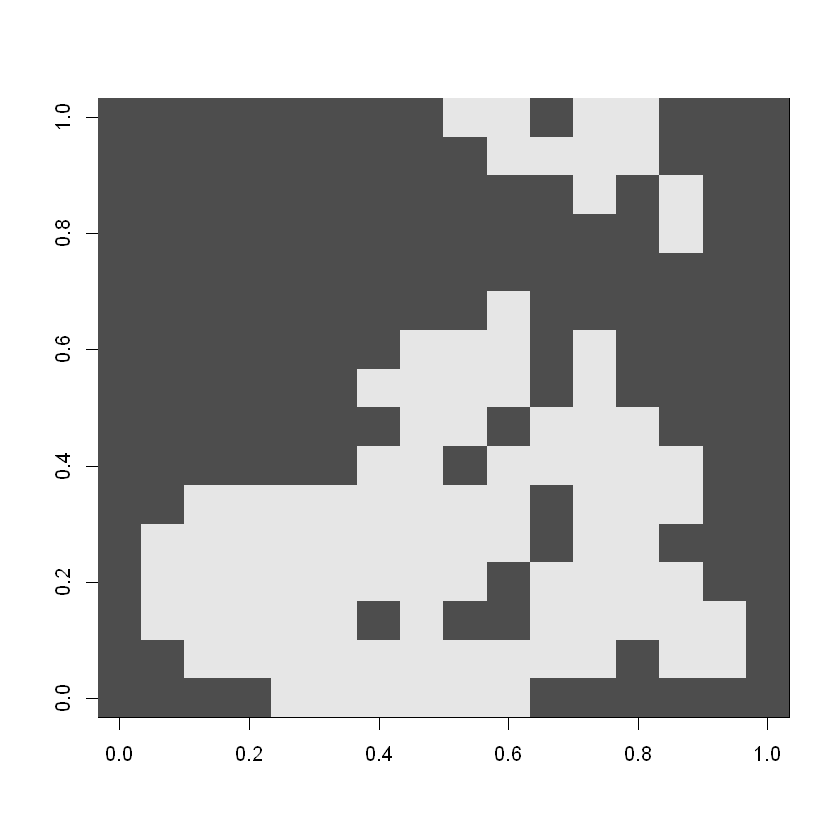

In [ ]:
ii <- seq(1,dim(Nmatu[,-1])[2])[tt<alfa/256]
image(t(matrix(as.numeric(log10(tt)),16,16,byrow=T))[,16:1], col = gray.colors(33))
Picimage <- rep(0,256)
Picimage[ii] <- 1
image(t(matrix(as.numeric(Picimage),16,16,byrow=T))[,16:1], col = gray.colors(33))
#
p.adj<-p.adjust(tt,"BH")
ii <- seq(1,dim(Nmatu[,-1])[2])[p.adj<alfa]
Picimage <- rep(0,256)
Picimage[ii] <- 1
image(t(matrix(as.numeric(Picimage),16,16,byrow=T))[,16:1], col = gray.colors(33))

Finally, let's revisit the SA heart disease data. Does p-value correction or multiple testing correction make a difference here?

In [ ]:
library(ElemStatLearn)
data(SAheart)
SAheart$famhist <- as.numeric(SAheart$famhist)
mm <- glm(chd ~ ., data=SAheart, family="binomial")
summary(mm) # 5 significant coefficients, but also 9 tests!
#
pvals<-summary(mm)$coef[2:10,4]
pvalsB<-pvals*9
pvalsBH<-p.adjust(pvals,"BH")
dd<-as.data.frame(round(cbind(pvals,pvalsB,pvalsBH),3))
names(dd)<-c("raw P", "Bonferroni","BH")
row.names(dd)<-names(SAheart)[-3]
dd



Call:
glm(formula = chd ~ ., family = "binomial", data = SAheart)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.0760913  1.3404862  -5.279  1.3e-07 ***
sbp          0.0065040  0.0057304   1.135 0.256374    
tobacco      0.0793764  0.0266028   2.984 0.002847 ** 
ldl          0.1739239  0.0596617   2.915 0.003555 ** 
adiposity    0.0185866  0.0292894   0.635 0.525700    
famhist      0.9253704  0.2278940   4.061  4.9e-05 ***
typea        0.0395950  0.0123202   3.214 0.001310 ** 
obesity     -0.0629099  0.0442477  -1.422 0.155095    
alcohol      0.0001217  0.0044832   0.027 0.978350    
age          0.0452253  0.0121298   3.728 0.000193 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 596.11  on 461  degrees of freedom
Residual deviance: 472.14  on 452  degrees of freedom
AIC: 492.14

Number of Fisher Scoring iterations: 5


,raw P,Bonferroni,BH
,<dbl>,<dbl>,<dbl>
sbp,0.256,2.307,0.330
tobacco,0.003,0.026,0.006
adiposity,0.004,0.032,0.006
famhist,0.526,4.731,0.591
typea,0.000,0.000,0.000
obesity,0.001,0.012,0.004
alcohol,0.155,1.396,0.233
age,0.978,8.805,0.978
chd,0.000,0.002,0.001
